In [12]:
print("We'll need some tools for clustering.")

We'll need some tools for clustering.


In [13]:
#the following installations were done:
#pip install xgboost (received 1.2.4 which is current 09/15/2020)
#pip install fastcluster
#conda install -c conda-forge hdbscan
#conda install -c conda-forge tslearn
#conda install -c conda-forge lightgbm
#conda install -c conda-forge/label/cf201901 lightgbm
#conda install -c conda-forge/label/cf202003 lightgmb

In [14]:
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

'''Algos'''
from sklearn.linear_model import LogisticRegression
#from slearn.ensemble import RandomForestClassifier
#import xgboost as xgb apparently python 64 is needed, but I have 32
import lightgbm as lgb

print("imports")

imports


(1797, 64)


<Figure size 432x288 with 0 Axes>

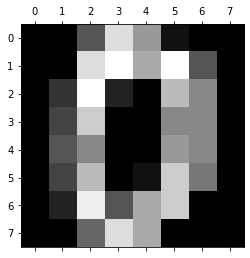

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
#sklearn.datasets.load_digits(*, n_class=10, return_X_y=False, as_frame=False)
plt.gray()
plt.matshow(digits.images[0])
plt.show()

Algos
Computing embedding
Done.
ward :	0.42s
average :	0.35s
complete :	0.32s
single :	0.12s


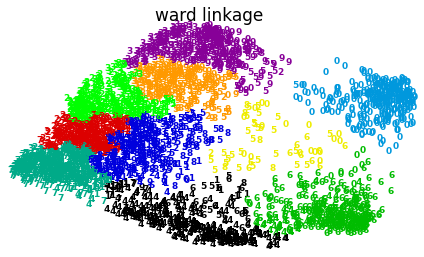

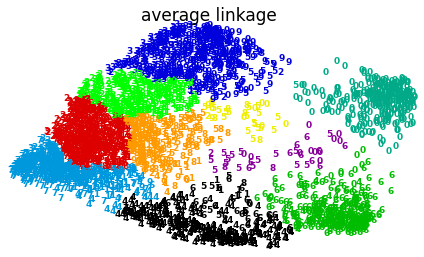

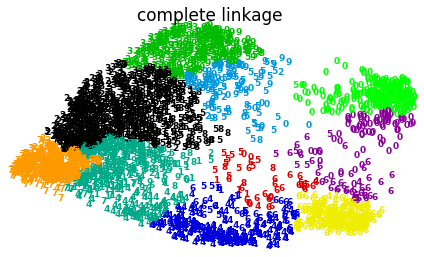

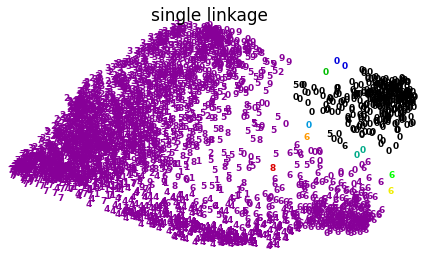

In [16]:
# Authors: Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2014

print(__doc__)
from time import time

import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

from sklearn import manifold, datasets

X, y = datasets.load_digits(return_X_y=True)
n_samples, n_features = X.shape

np.random.seed(0)

def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: ndimage.shift(x.reshape((8, 8)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y


X, y = nudge_images(X, y)


#----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red) #problem
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

Algos
n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.25s	69510	0.610	0.657	0.633	0.481	0.629	0.129
random   	0.21s	69907	0.633	0.674	0.653	0.518	0.649	0.131
PCA-based	0.03s	70768	0.668	0.695	0.681	0.558	0.678	0.142
__________________________________________________________________________________


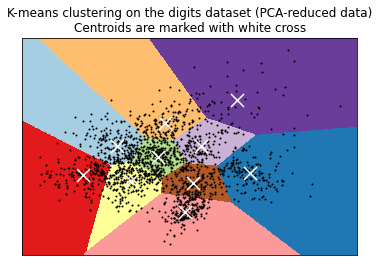

In [17]:
print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

X_digits, y_digits = load_digits(return_X_y=True)
data = scale(X_digits)

n_samples, n_features = data.shape
n_digits = len(np.unique(y_digits))
labels = y_digits

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [18]:
#current_path = os.getcwd()
#file='\\datasets\\mnist_data\\mnist.pkl.gz'

#f = gzip.open(current_path+file, 'rb')
#train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
#f.close()

#X_train, y_train = train_set[0], train_set[1]#labelled data
#X_validation, y_validation = validation_set[0], validation_set[1]
#X_test, y_test - test_set[0], test_set[1]

#create pandas dataframes from the datasets
#train_index = range(0,len(X_train))
#validation_index = range(len(X_train), len(X_train)+len(X_validation))
#test_index = range(len(X_train)+len(X_validation), len(X_train)+len(X_validation)+len(X_test))
#X_train = pd.DataFrame(data=X_train, index=train_index)
#y_train = pd.DataFrame(data=y_train, index=train_index)

#X_validation = pd.DataFrame(data=X_validation, index=validation_index)
#y_validation = pd.DataFrame(data=y_validation, index=validation_index)

#X_test = pd.DataFrame(data=X_test, index=test_index)
#y_test = pd.DataFrame(data=y_test, index=test_index)


In [19]:
#Principal Components Analysis
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCS, index=train_index)

NameError: name 'X_train' is not defined